In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013.csv


## Import một số thư viện cần thiết

In [2]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from torchvision import transforms
import timm  # EfficientNetB4
import warnings
import torch.optim as optim
warnings.filterwarnings('ignore')

## Xử lý dữ liệu

In [4]:
from scipy.stats import zscore
# 1. Đọc dữ liệu
df = pd.read_csv("/kaggle/input/fer2013.csv")

# 2. Tiền xử lý và thống kê ảnh
df['pixels_array'] = df['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=np.float32))
df['pixel_mean'] = df['pixels_array'].apply(np.mean)
df['pixel_std'] = df['pixels_array'].apply(np.std)
df['pixel_min'] = df['pixels_array'].apply(np.min)
df['pixel_max'] = df['pixels_array'].apply(np.max)

# 3. Gắn cờ ảnh mờ & nhiễu
df['is_blurred'] = (df['pixel_mean'] < 40) & (df['pixel_std'] < 15)
df['is_noisy'] = df['pixel_std'] > 70

# 4. Gắn cờ ảnh lỗi
def is_corrupted(row):
    return (
        row['pixel_mean'] < 10 or
        row['pixel_mean'] > 245 or
        row['pixel_std'] < 5 or
        (row['pixel_max'] - row['pixel_min']) < 20 or
        row['pixel_max'] < 30 or
        row['pixel_min'] > 225
    )
df['corrupted'] = df.apply(is_corrupted, axis=1)

# 5. Tính z-score để loại outlier trong mỗi class (dựa vào pixel_mean và pixel_std)
df['z_mean'] = df.groupby('emotion')['pixel_mean'].transform(zscore)
df['z_std'] = df.groupby('emotion')['pixel_std'].transform(zscore)

# Đặt ngưỡng loại outlier (ví dụ: z > 2.5)
df['is_outlier'] = (df['z_mean'].abs() > 2.5) | (df['z_std'].abs() > 2.5)

# 6. Giữ lại ảnh sạch
clean_df = df[
    (~df['is_blurred']) &
    (~df['corrupted']) &
    (~df['is_outlier'])
].copy().reset_index(drop=True)

# 7. Thống kê
print(f"Số ảnh mờ bị loại:        {df['is_blurred'].sum()}")
print(f"Số ảnh lỗi bị loại:       {df['corrupted'].sum()}")
print(f"Số outlier bị loại:       {df['is_outlier'].sum()}")
print(f"Tổng số ảnh còn lại:      {len(clean_df)}")

# 8. Lưu file CSV mới
clean_df[['emotion', 'pixels', 'Usage']].to_csv("fer2013_new.csv", index=False)
print(" Đã lưu file fer2013_new.csv")


Số ảnh mờ bị loại:        16
Số ảnh lỗi bị loại:       20
Số outlier bị loại:       755
Tổng số ảnh còn lại:      35132
 Đã lưu file fer2013_new.csv


In [5]:
label_to_text = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4:'sadness',
                5: 'surprise', 6: 'neutral'}

## Hiển thị ảnh trước khi training

In [6]:
import matplotlib.pyplot as plt
# Hiển thị ảnh sau khi xử lý data
def show_clean_samples(df_clean, label_to_text, n_samples=5):
    fig = plt.figure(figsize=(18, 18))
    k = 1
    num_classes = df_clean['emotion'].nunique()

    for label in sorted(df_clean['emotion'].unique()):
        samples = df_clean[df_clean['emotion'] == label].sample(n_samples, random_state=42)

        for _, row in samples.iterrows():
            pixels = np.array(row['pixels_array']).reshape(48, 48)
            ax = plt.subplot(num_classes, n_samples, k)
            ax.imshow(pixels, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(label_to_text[label])
            k += 1

    plt.tight_layout()
    plt.show()



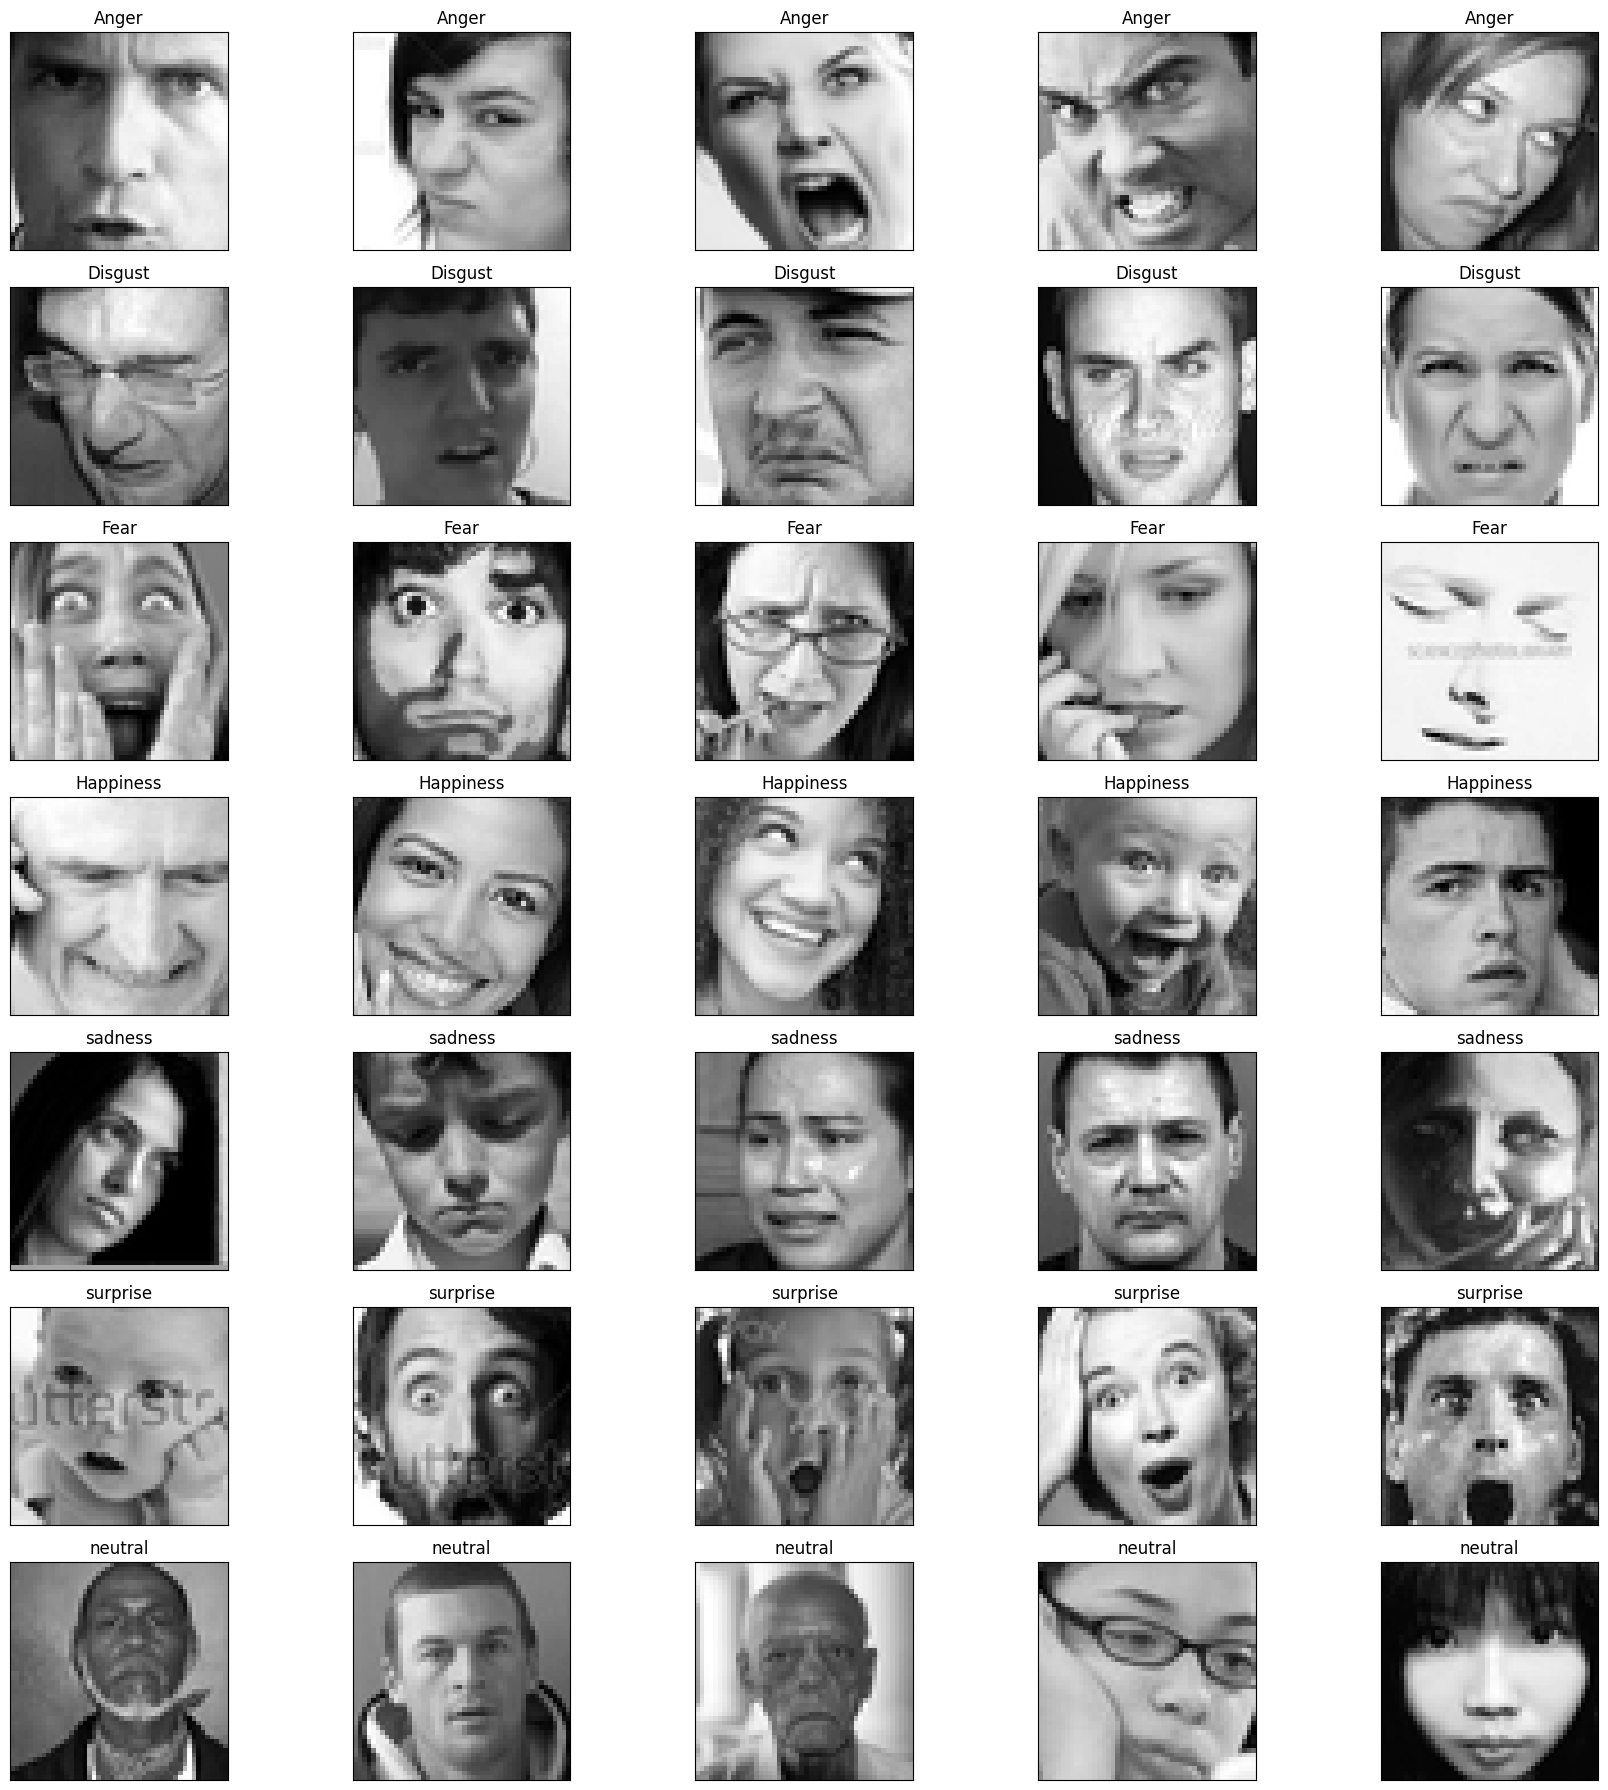

In [7]:
show_clean_samples(clean_df, label_to_text, n_samples=5)

## Số lượng emotion ở mỗi class

In [8]:
df['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [9]:
# Split the data into features and target variable

X_data = df['pixels']
y_data = df['emotion']

In [10]:
df.isnull().sum()

emotion         0
pixels          0
Usage           0
pixels_array    0
pixel_mean      0
pixel_std       0
pixel_min       0
pixel_max       0
is_blurred      0
is_noisy        0
corrupted       0
z_mean          0
z_std           0
is_outlier      0
dtype: int64

In [11]:
X_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
35882    50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883    178 174 172 173 181 188 191 194 196 199 200 20...
35884    17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885    30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886    19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...
Name: pixels, Length: 35887, dtype: object

In [12]:
# Normalize the data
x_data = np.array(list(map(str.split, X_data)), np.float32)
x_data

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.],
       ...,
       [ 17.,  17.,  16., ..., 154., 133., 113.],
       [ 30.,  28.,  28., ...,  35.,  30.,  28.],
       [ 19.,  13.,  14., ..., 189., 199., 201.]], dtype=float32)

In [13]:
x_data = x_data/255

In [14]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(35887, 48, 48, 1)

In [15]:
# Split the data into train test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size= 0.2, random_state = 42)

In [16]:
x_train.shape, x_test.shape, y_train.shape

((28709, 48, 48, 1), (7178, 48, 48, 1), (28709,))

In [17]:
from keras.utils import to_categorical

2025-07-13 13:14:16.123972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752412456.485551      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752412456.588374      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
# Perfom one-hot encoding on labels
y_train_encoded = to_categorical(y_train, 7)
y_train_encoded.shape

(28709, 7)

In [19]:
y_test_encoded = to_categorical(y_test, 7)
y_test_encoded.shape

(7178, 7)

In [20]:
x_data_rgb = np.repeat(x_data, 3, axis=-1)  # chuyển (48, 48, 1) → (48, 48, 3)


In [21]:
x_train_rgb = np.repeat(x_train, 3, axis=-1)
x_test_rgb = np.repeat(x_test, 3, axis=-1)


In [22]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
class FERCSV_Dataset(Dataset):
    def __init__(self, csv_path, usage="Training", transform=None, image_size=380):
        self.data = pd.read_csv(csv_path)
        self.data = self.data[self.data['Usage'] == usage].reset_index(drop=True)
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        label = int(row['emotion'])
        pixels = np.fromstring(row['pixels'], dtype=np.uint8, sep=' ').reshape(48, 48)

        # Resize & chuyển sang RGB
        image = cv2.resize(pixels, (self.image_size, self.image_size), interpolation=cv2.INTER_CUBIC)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, label

In [23]:
import torchvision.transforms as transforms
from torchvision import transforms
def get_train_transform(image_size=380):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomCrop(image_size, padding=10),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

def get_val_transform(image_size=380):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

In [24]:
def calculate_class_weights(dataloader):
    all_labels = []
    for _, labels in dataloader:
        all_labels.extend(labels.numpy())

    import numpy as np
    class_counts = np.bincount(np.array(all_labels))
    total = len(all_labels)
    n_classes = len(class_counts)
    weights = total / (n_classes * class_counts)
    return torch.FloatTensor(weights)


In [25]:
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader

def get_train_val_loaders_from_csv(csv_path, batch_size=8, image_size=380, num_workers=4):
    train_dataset = FERCSV_Dataset(
        csv_path=csv_path,
        usage="Training",
        transform=get_train_transform(image_size),
        image_size=image_size
    )

    val_dataset = FERCSV_Dataset(
        csv_path=csv_path,
        usage="PublicTest",
        transform=get_val_transform(image_size),
        image_size=image_size
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader



In [26]:
import torch
import torch.nn.functional as F

def mixup_data(x, y, alpha=1.0):
    """Trộn dữ liệu đầu vào và nhãn bằng Mixup."""
    if alpha > 0:
        lam = torch.distributions.Beta(alpha, alpha).sample().item()
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


In [27]:
# Loss Mixup
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [28]:
csv_path = "/kaggle/working/fer2013_new.csv"
train_loader, val_loader = get_train_val_loaders_from_csv(csv_path)


In [29]:
test_dataset = FERCSV_Dataset(
    csv_path=csv_path,
    usage="PrivateTest",
    transform=get_val_transform()
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)


## Model 

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=7)
model = model.to(device)

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [32]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            print(f" EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [33]:
from tqdm import tqdm

# Hàm evaluate đánh giá trên validation set
def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


# Lưu lịch sử
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

num_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
early_stopping = EarlyStopping(patience=8)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch {epoch+1} — Current LR: {current_lr:.6f}")

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        images, y_a, y_b, lam = mixup_data(images, labels, alpha=0.4)

        optimizer.zero_grad()
        outputs = model(images)
        loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
        loss.backward()
        optimizer.step()

    
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        running_loss += loss.item() * images.size(0)
        train_loss = running_loss / total
        train_acc = correct / total
        # Tạm thời chỉ log loss/acc trong train
        loop.set_postfix(loss=train_loss, acc=train_acc)

    # === Evaluate ===
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Cập nhật thanh tiến trình sau khi Evaluate
    loop.set_postfix({
        'loss': train_loss,
        'acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    })

    # Lưu lịch sử
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    scheduler.step(val_loss)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break


Epoch 1 — Current LR: 0.001000


Epoch 1/100 [Train]: 100%|██████████| 3514/3514 [19:14<00:00,  3.04it/s, acc=0.394, loss=1.35]


Validation Loss: 1.0038, Accuracy: 0.6349

Epoch 2 — Current LR: 0.001000


Epoch 2/100 [Train]: 100%|██████████| 3514/3514 [19:19<00:00,  3.03it/s, acc=0.435, loss=1.2]


Validation Loss: 0.9774, Accuracy: 0.6403

Epoch 3 — Current LR: 0.001000


Epoch 3/100 [Train]: 100%|██████████| 3514/3514 [19:19<00:00,  3.03it/s, acc=0.45, loss=1.13]


Validation Loss: 0.9314, Accuracy: 0.6667

Epoch 4 — Current LR: 0.001000


Epoch 4/100 [Train]: 100%|██████████| 3514/3514 [19:19<00:00,  3.03it/s, acc=0.462, loss=1.09]


Validation Loss: 0.9028, Accuracy: 0.6794

Epoch 5 — Current LR: 0.001000


Epoch 5/100 [Train]: 100%|██████████| 3514/3514 [19:19<00:00,  3.03it/s, acc=0.472, loss=1.05]


Validation Loss: 0.8771, Accuracy: 0.6806

Epoch 6 — Current LR: 0.001000


Epoch 6/100 [Train]: 100%|██████████| 3514/3514 [19:18<00:00,  3.03it/s, acc=0.493, loss=1]


Validation Loss: 0.9178, Accuracy: 0.6755
 EarlyStopping counter: 1/8

Epoch 7 — Current LR: 0.001000


Epoch 7/100 [Train]: 100%|██████████| 3514/3514 [19:19<00:00,  3.03it/s, acc=0.501, loss=0.961]


Validation Loss: 0.8956, Accuracy: 0.6874
 EarlyStopping counter: 2/8

Epoch 8 — Current LR: 0.001000


Epoch 8/100 [Train]: 100%|██████████| 3514/3514 [19:19<00:00,  3.03it/s, acc=0.498, loss=0.943]


Validation Loss: 0.9039, Accuracy: 0.6908
 EarlyStopping counter: 3/8

Epoch 9 — Current LR: 0.000500


Epoch 9/100 [Train]: 100%|██████████| 3514/3514 [19:19<00:00,  3.03it/s, acc=0.55, loss=0.814]


Validation Loss: 0.8779, Accuracy: 0.7052
 EarlyStopping counter: 4/8

Epoch 10 — Current LR: 0.000500


Epoch 10/100 [Train]: 100%|██████████| 3514/3514 [19:20<00:00,  3.03it/s, acc=0.557, loss=0.745]


Validation Loss: 0.9136, Accuracy: 0.6999
 EarlyStopping counter: 5/8

Epoch 11 — Current LR: 0.000500


Epoch 11/100 [Train]: 100%|██████████| 3514/3514 [19:19<00:00,  3.03it/s, acc=0.569, loss=0.716]


Validation Loss: 0.9804, Accuracy: 0.6982
 EarlyStopping counter: 6/8

Epoch 12 — Current LR: 0.000250


Epoch 12/100 [Train]: 100%|██████████| 3514/3514 [19:19<00:00,  3.03it/s, acc=0.583, loss=0.648]


Validation Loss: 0.9909, Accuracy: 0.7078
 EarlyStopping counter: 7/8

Epoch 13 — Current LR: 0.000250


Epoch 13/100 [Train]: 100%|██████████| 3514/3514 [19:19<00:00,  3.03it/s, acc=0.596, loss=0.619]


Validation Loss: 0.9870, Accuracy: 0.7070
 EarlyStopping counter: 8/8
Early stopping triggered.


## Đánh giá trên tập test

In [34]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 0.9506
Test Accuracy: 0.7220


## Biểu đồ sau khi huấn luyện 

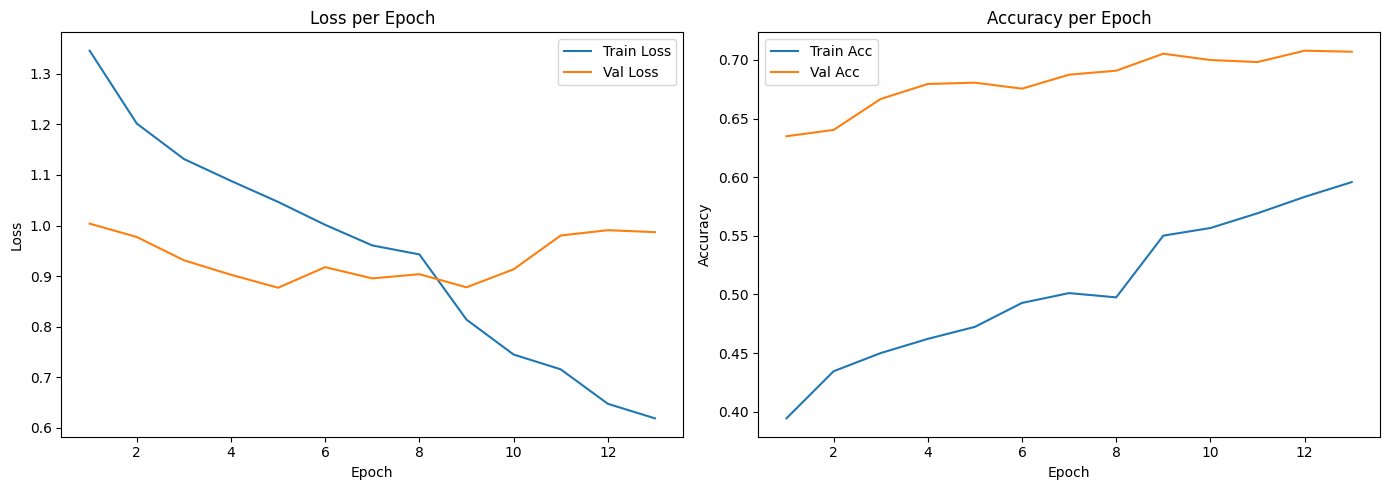

In [35]:
epochs = range(1, len(history["train_loss"]) + 1)
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


## Ma trận nhầm lẫn


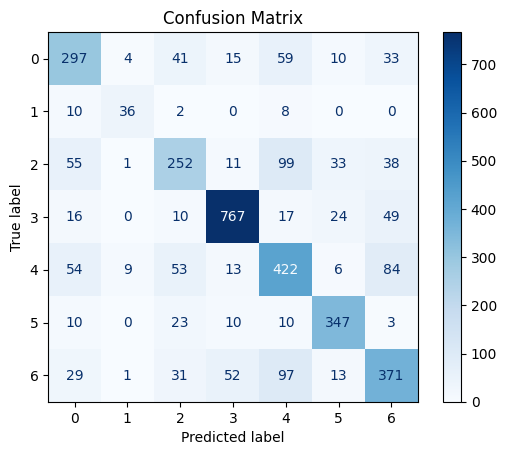

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Dự đoán trên tập validation
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Hiển thị ma trận nhầm lẫn
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

## Predict ảnh sau khi test

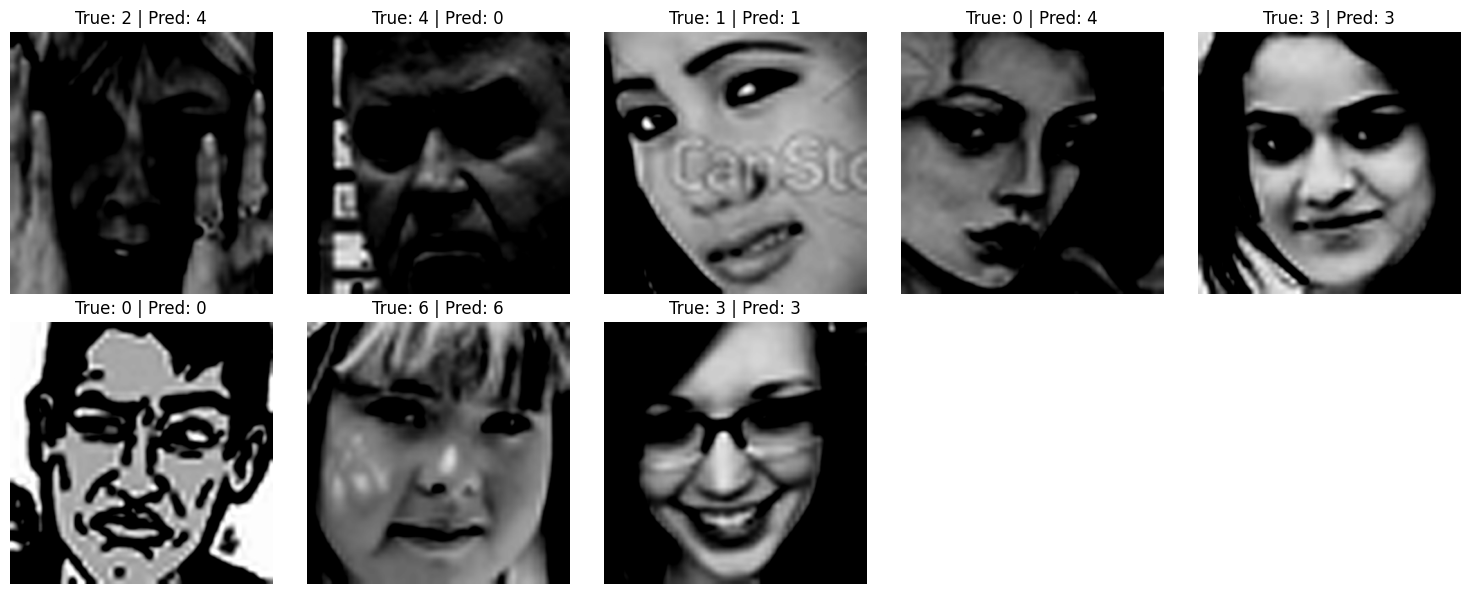

In [37]:
import matplotlib.pyplot as plt
import random
import torch

# Đặt model về chế độ đánh giá
model.eval()

# Lấy 1 batch từ val_loader
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

# Dự đoán
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Chọn ngẫu nhiên 10 ảnh (hoặc ít hơn nếu batch < 10)
num_samples = min(10, len(images))
indices = random.sample(range(len(images)), num_samples)

# Hiển thị ảnh
plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices):
    image = images[idx].cpu()
    true_label = labels[idx].item()
    predicted_label = preds[idx].item()

    # Chuyển về HWC nếu có 3 kênh
    if image.shape[0] == 3:
        image = image.permute(1, 2, 0)
    elif image.shape[0] == 1:  # Nếu là ảnh xám
        image = image.squeeze(0)

    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.title(f"True: {true_label} | Pred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Lưu model

In [38]:
torch.save(model.state_dict(),"Final_Project_DPL302m_ResNet.h5")
print(" Hoàn tất ")

 Hoàn tất 
